In [24]:
import mlrose_hiive
import numpy as np
import pandas as pd
np.random.seed(44)

def getFitnessInfo(runStats):
    lastIteration = runStats[runStats.Iteration != 0].reset_index()
    fitnessMean = lastIteration.Fitness.mean()
    fitnessMax = lastIteration.Fitness.max()
    maxTime = lastIteration.Time.max()
    meanTime = lastIteration.Time.mean()
    print('fitnessMax: ', fitnessMax)
    print('fitnessMean: ', fitnessMean)
    print('maxTime: ', maxTime, 'sec')
    print('meanTime: ', meanTime, 'sec')

def plotFitness(algoValue, title, xLabel, yLabel):
    bestCurve = algoValue['bestCurve']
    ax = bestCurve.Fitness.plot(marker='.', markersize=2, figsize=(10,10), grid=1, title=title)
    ax.set_ylabel(yLabel)
    ax.set_xlabel(xLabel)
    return ax

def getBestValues(curves, algo):
    value = {}
    bestIndexCurve = curves.Fitness.idxmax()
    if(algo == "sa"):
        bestDecay = curves.iloc[bestIndexCurve].Temperature
        bestCurve = curves.loc[curves.Temperature == bestDecay, :]
    elif(algo == "rhc"):
        bestDecay = curves.iloc[bestIndexCurve].current_restart
        bestCurve = curves.loc[curves.current_restart == bestDecay, :]
        
    bestCurve.reset_index(inplace=True)
    value['bestCurve'] = bestCurve
    value['bestDecay'] = bestDecay
    return value

def getFitnessByFeatures(runStats, algo):
    lastIteration = runStats[runStats.Iteration != 0].reset_index()
    
    print("Overall Max Fitness: ", lastIteration.Fitness.max())
    print("Overall Mean Fitness: ", lastIteration.Fitness.mean())
    print("Overall Max Time: ", lastIteration.Time.max())
    print("Overall Mean Time: ", lastIteration.Time.mean())
    
    print('==========================================')
    
    if(algo == "ga"):
        mutationRateFitnessMean = lastIteration.groupby("Mutation Rate").Fitness.mean()
        populationSizeFitnessMean = lastIteration.groupby("Population Size").Fitness.mean()
        populationSizeTimeMean = lastIteration.groupby("Population Size").Time.mean() 
        print('MR      Mean Fitness:       ', mutationRateFitnessMean)

    elif(algo == "mimic"):
        keepPercentFitnessMean = lastIteration.groupby("Keep Percent").Fitness.mean()
        populationSizeFitnessMean = lastIteration.groupby("Population Size").Fitness.mean()
        populationSizeTimeMean = lastIteration.groupby("Population Size").Time.mean()
        print('keep%      Mean Fitness:       ', keepPercentFitnessMean)

    print('PS      Mean Fitness:      ', populationSizeFitnessMean)
    print('PS      Mean Time:      ', populationSizeTimeMean)

In [12]:
knapsackLen = 250
knapsackWeights = np.random.uniform(10, 50, knapsackLen)
knapsackValues = np.random.uniform(20, 30, knapsackLen)
maxWeightPct = 0.5

knapsackProblem = mlrose_hiive.KnapsackOpt(weights=knapsackWeights,
                                          values=knapsackValues,
                                          max_weight_pct=maxWeightPct)

fitnessMax:  3326.8600692644723
fitnessMean:  2053.6200480398884
maxTime:  41.855516761 sec
meanTime:  14.778425274128711 sec
CPU times: user 41.7 s, sys: 296 ms, total: 42 s
Wall time: 42.2 s


<AxesSubplot:title={'center':'Fitness vs Iteration'}, xlabel='Iterations', ylabel='Fitness Value'>

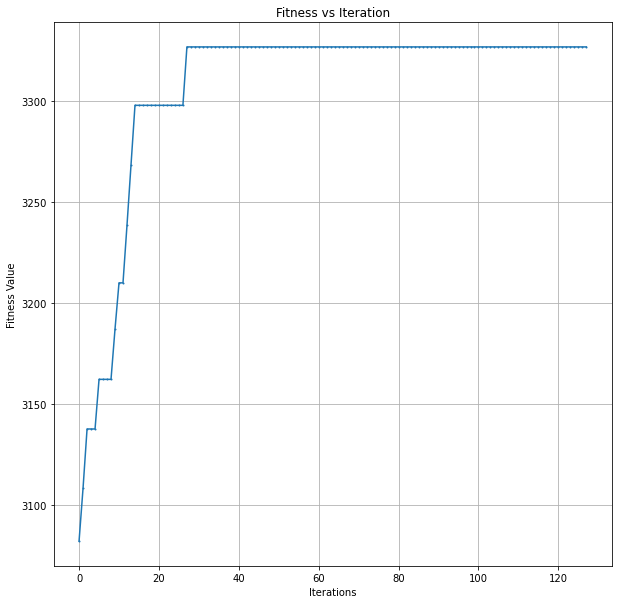

In [3]:
%%time
##Random Hill Climb
rhc = mlrose_hiive.RHCRunner(knapsackProblem, experiment_name="RCH_final", iteration_list=[1000],
                                       seed=44, max_attempts=100, 
                                       restart_list=[100])

rhcRunStats, rhcRunCurves = rhc.run()
rhcVal = getBestValues(rhcRunCurves, 'rhc')

getFitnessInfo(rhcRunStats)
plotFitness(rhcVal, "Fitness vs Iteration","Iterations", "Fitness Value")

Best Decay {'bestCurve':       index  Iteration      Time      Fitness  FEvals Temperature  max_iters
0      4718          0  0.000219  3005.804100     0.0         500       1000
1      4719          1  0.003369  2977.135890     2.0         500       1000
2      4720          2  0.003676  3003.754351     4.0         500       1000
3      4721          3  0.003917  2977.060576     6.0         500       1000
4      4722          4  0.004010  2956.736165     8.0         500       1000
...     ...        ...       ...          ...     ...         ...        ...
996    5714        996  0.017871  3453.168266  1469.0         500       1000
997    5715        997  0.017996  3453.168266  1470.0         500       1000
998    5716        998  0.018123  3453.168266  1471.0         500       1000
999    5717        999  0.018249  3453.168266  1472.0         500       1000
1000   5718       1000  0.018375  3453.168266  1473.0         500       1000

[1001 rows x 7 columns], 'bestDecay': ExpDecay(ini

<AxesSubplot:title={'center':'Fitness vs Iterations (SA)'}, xlabel='Iterations', ylabel='Fitness'>

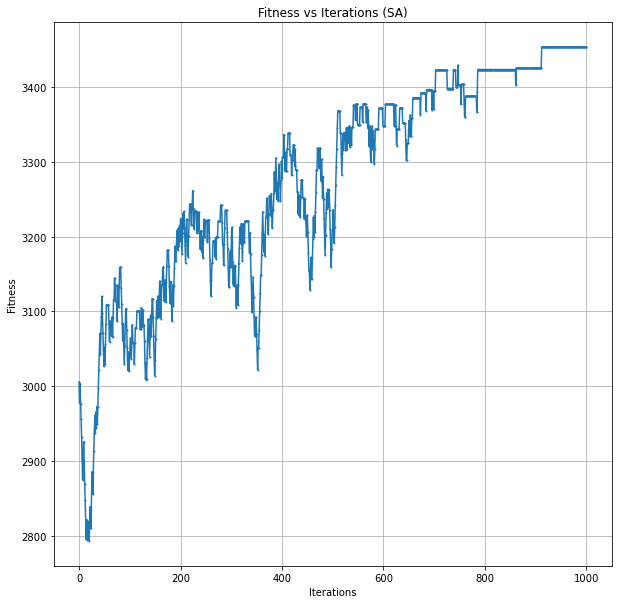

In [30]:
%%time
##Simulated Annealing
sa = mlrose_hiive.SARunner(knapsackProblem, experiment_name="SA_final", iteration_list=[1000],
                           temperature_list=[1, 10, 25, 50, 100, 200, 500, 1000], decay_list=[mlrose_hiive.GeomDecay, mlrose_hiive.ExpDecay], seed=44, max_attempts=100)

saRunStats, saRunCurves = sa.run()
saVal = getBestValues(saRunCurves, 'sa')
print("Best Decay", saVal)

getFitnessInfo(saRunStats)
plotFitness(saVal, 'Fitness vs Iterations (SA)', 'Iterations', 'Fitness')

In [5]:
%%time
##Genetic Algorithm
ga = mlrose_hiive.GARunner(knapsackProblem, experiment_name='GA_final', iteration_list=[1000], 
                           population_sizes=[100, 500, 1000], mutation_rates=[0.1, 0.25, 0.5, 0.9], 
                           seed=44, max_attempts=100)

gaRunStats, gaRunCurves = ga.run()
getFitnessByFeatures(gaRunStats, 'ga')

Overall Max Fitness:  4106.519998222297
Overall Mean Fitness:  4084.868581128634
Overall Max Time:  29.623634554999995
Overall Mean Time:  13.291412126250002
MR      Mean Fitness:        Mutation Rate
0.10    4072.862340
0.25    4074.282686
0.50    4090.200817
0.90    4102.128482
Name: Fitness, dtype: float64
PS      Mean Fitness:       Population Size
100     4043.897469
500     4104.607316
1000    4106.100958
Name: Fitness, dtype: float64
PS      Mean Time:       Population Size
100      3.515517
500     12.450083
1000    23.908636
Name: Time, dtype: float64
CPU times: user 2min 39s, sys: 246 ms, total: 2min 39s
Wall time: 2min 39s


In [6]:
getFitnessByFeatures(gaRunStats, 'ga')

Overall Max Fitness:  4106.519998222297
Overall Mean Fitness:  4084.868581128634
Overall Max Time:  29.623634554999995
Overall Mean Time:  13.291412126250002
MR      Mean Fitness:        Mutation Rate
0.10    4072.862340
0.25    4074.282686
0.50    4090.200817
0.90    4102.128482
Name: Fitness, dtype: float64
PS      Mean Fitness:       Population Size
100     4043.897469
500     4104.607316
1000    4106.100958
Name: Fitness, dtype: float64
PS      Mean Time:       Population Size
100      3.515517
500     12.450083
1000    23.908636
Name: Time, dtype: float64


In [4]:
%%time
##Mimic Algorithm
mimic = mlrose_hiive.MIMICRunner(knapsackProblem, experiment_name='MIMIC_final', iteration_list=[1000], use_fast_mimic=True,
                                population_sizes=[100,500], keep_percent_list=[0.1, 0.25, 0.5, 0.9],
                                seed=44, max_attempts=100)

mimicRunStats, mimicRunCurves = mimic.run()
getFitnessByFeatures(mimicRunStats, 'mimic')

Overall Max Fitness:  4066.850519738009
Overall Mean Fitness:  3687.2101048243394
Overall Max Time:  183.23082343399994
Overall Mean Time:  74.70519536349998
keep%      Mean Fitness:        Keep Percent
0.10    3720.799418
0.25    3826.066507
0.50    3861.191097
0.90    3340.783397
Name: Fitness, dtype: float64
PS      Mean Fitness:       Population Size
100    3498.421251
500    3875.998959
Name: Fitness, dtype: float64
PS      Mean Time:       Population Size
100     22.664525
500    126.745865
Name: Time, dtype: float64
CPU times: user 8min 3s, sys: 1min 52s, total: 9min 56s
Wall time: 9min 57s
